## Import modules

In [90]:
import gensim
import logging
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import os
import re
from sklearn.manifold import TSNE
import string
import tensorflow as tf
from tensorboard.plugins import projector

print(f"Gensim version: {gensim.__version__}") 
print(f"TensorFlow version: {tf.__version__}")

Gensim version: 3.8.0
TensorFlow version: 2.1.0


## Config

In [47]:
# For displaying gensim logs
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Directory with raw files
TEXT_DIR  = "/home/tdelatte/projects/notebooks/data/word_embeddings/" 

# Directory for saving checkpoints
MODEL_DIR = "wordemb_model/"

EMBEDDING_SIZE = 300

## Preprocessing

In [73]:
def clean_doc(doc):
    # Lowercase
    doc = doc.lower()
    # Remove numbers
    doc = re.sub(r"[0-9]+", "", doc)
    # Split in tokens
    tokens = doc.split()
    # Remove punctuation
    try:
        tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    except TypeError:
        print("Error is here!")
    # Tokens with less then two characters will be ignored
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

def read_files(path):
    documents = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    clean = []
    print(len(documents))
    tokenize  = lambda x: gensim.utils.simple_preprocess(x)
    for d in documents:
        with open(f"{path}/{d}", encoding='utf-8') as f:
            doc = f.read()
            print(len(doc))
            doc = clean_doc(doc)
            clean.append(tokenize(doc))
    return clean

In [74]:
# Load and clean data
docs = read_files(TEXT_DIR)

print('Number of documents: %i' % len(docs))

7
1187249
1059021
474428
1227023
676977
1608762
531707
Number of documents: 7


## Training the model

In [76]:
model = gensim.models.Word2Vec(docs, size=EMBEDDING_SIZE, sg=1, window=10, min_count=3, workers=4)

2020-06-12 12:26:31,360 : INFO : collecting all words and their counts
2020-06-12 12:26:31,362 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-12 12:26:31,642 : INFO : collected 22425 word types from a corpus of 1103523 raw words and 7 sentences
2020-06-12 12:26:31,643 : INFO : Loading a fresh vocabulary
2020-06-12 12:26:31,724 : INFO : effective_min_count=3 retains 11895 unique words (53% of original 22425, drops 10530)
2020-06-12 12:26:31,725 : INFO : effective_min_count=3 leaves 1090047 word corpus (98% of original 1103523, drops 13476)
2020-06-12 12:26:31,786 : INFO : deleting the raw counts dictionary of 22425 items
2020-06-12 12:26:31,787 : INFO : sample=0.001 downsamples 52 most-common words
2020-06-12 12:26:31,788 : INFO : downsampling leaves estimated 821564 word corpus (75.4% of prior 1090047)
2020-06-12 12:26:31,838 : INFO : estimated required memory for 11895 words and 300 dimensions: 34495500 bytes
2020-06-12 12:26:31,839 : INFO : resetti

In [77]:
# Save the model
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
model.save(os.path.join(MODEL_DIR,'word2vec'))

2020-06-12 12:26:55,675 : INFO : saving Word2Vec object under wordemb_model/word2vec, separately None
2020-06-12 12:26:55,677 : INFO : not storing attribute vectors_norm
2020-06-12 12:26:55,678 : INFO : not storing attribute cum_table
2020-06-12 12:26:56,102 : INFO : saved wordemb_model/word2vec


In [78]:
# Checkpoints and metadata

weights = model.wv.vectors
index_words = model.wv.index2word

vocab_size = weights.shape[0]
embedding_dim = weights.shape[1]

print('Shape of weights:', weights.shape)
print('Vocabulary size: %i' % vocab_size)
print('Embedding size: %i'  % embedding_dim)

with open(os.path.join(MODEL_DIR,'metadata.tsv'), 'w') as f:
    f.writelines("\n".join(index_words))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = 'embeddings'
embedding.metadata_path = './metadata.tsv'
projector.visualize_embeddings(MODEL_DIR, config)

tensor_embeddings = tf.Variable(model.wv.vectors, name='embeddings')

checkpoint = tf.compat.v1.train.Saver([tensor_embeddings])
checkpoint_path = checkpoint.save(sess=None, global_step=None, save_path=os.path.join(MODEL_DIR, "model.ckpt"))

Shape of weights: (11895, 300)
Vocabulary size: 11895
Embedding size: 300


2020-06-12 12:27:01,277 : WARNING : Saver is deprecated, please switch to tf.train.Checkpoint or tf.keras.Model.save_weights for training checkpoints. When executing eagerly variables do not necessarily have unique names, and so the variable.name-based lookups Saver performs are error-prone.


In [108]:
model = gensim.models.Word2Vec(sg=1,
                 size=100,
                 window=10,
                 min_count=30,
                 workers=4)
model.build_vocab(docs)
model.train(sentences=docs, total_examples=model.corpus_count, epochs=model.epochs)

2020-06-12 12:52:29,045 : INFO : collecting all words and their counts
2020-06-12 12:52:29,047 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-12 12:52:29,295 : INFO : collected 22425 word types from a corpus of 1103523 raw words and 7 sentences
2020-06-12 12:52:29,296 : INFO : Loading a fresh vocabulary
2020-06-12 12:52:29,313 : INFO : effective_min_count=30 retains 2836 unique words (12% of original 22425, drops 19589)
2020-06-12 12:52:29,314 : INFO : effective_min_count=30 leaves 1008542 word corpus (91% of original 1103523, drops 94981)
2020-06-12 12:52:29,331 : INFO : deleting the raw counts dictionary of 22425 items
2020-06-12 12:52:29,333 : INFO : sample=0.001 downsamples 57 most-common words
2020-06-12 12:52:29,334 : INFO : downsampling leaves estimated 729906 word corpus (72.4% of prior 1008542)
2020-06-12 12:52:29,353 : INFO : estimated required memory for 2836 words and 100 dimensions: 3686800 bytes
2020-06-12 12:52:29,355 : INFO : resettin

(350000, 5517615)

In [110]:
model.most_similar(positive=["gryffindor"], topn=10)

/home/tdelatte/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('refused', 0.9975051879882812),
 ('relieved', 0.9971591234207153),
 ('proved', 0.996979832649231),
 ('test', 0.9969589710235596),
 ('dying', 0.996813952922821),
 ('discuss', 0.996599555015564),
 ('mere', 0.996487021446228),
 ('afterward', 0.9964829683303833),
 ('loss', 0.9964531064033508),
 ('weapon', 0.9964077472686768)]

In [97]:
sim = model.similarity('harry', 'ron')
print("Similarity between 'harry' and 'ron' is {}".format(sim))

Similarity between 'harry' and 'ron' is 0.8997739553451538


/home/tdelatte/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


In [98]:
odd = model.doesnt_match(['harry', 'ron', 'hermione', 'voldemort'])
print(f"word that does not belong in the given list is : {odd}")

word that does not belong in the given list is : harry


/home/tdelatte/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


In [104]:
print(model.most_similar_cosmul(positive=["gryffindor", "malfoy"], negative=["potter"], topn=5))

[('knockturn', 1.1809988021850586), ('shy', 1.1767812967300415), ('background', 1.175654411315918), ('cuppa', 1.1727849245071411), ('doorknob', 1.171370267868042)]


/home/tdelatte/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


## t-SNE Visualization

In [86]:
# Inspired by code here: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(n_components=2, init="pca", n_iter=2500, random_state=32)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

/home/tdelatte/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


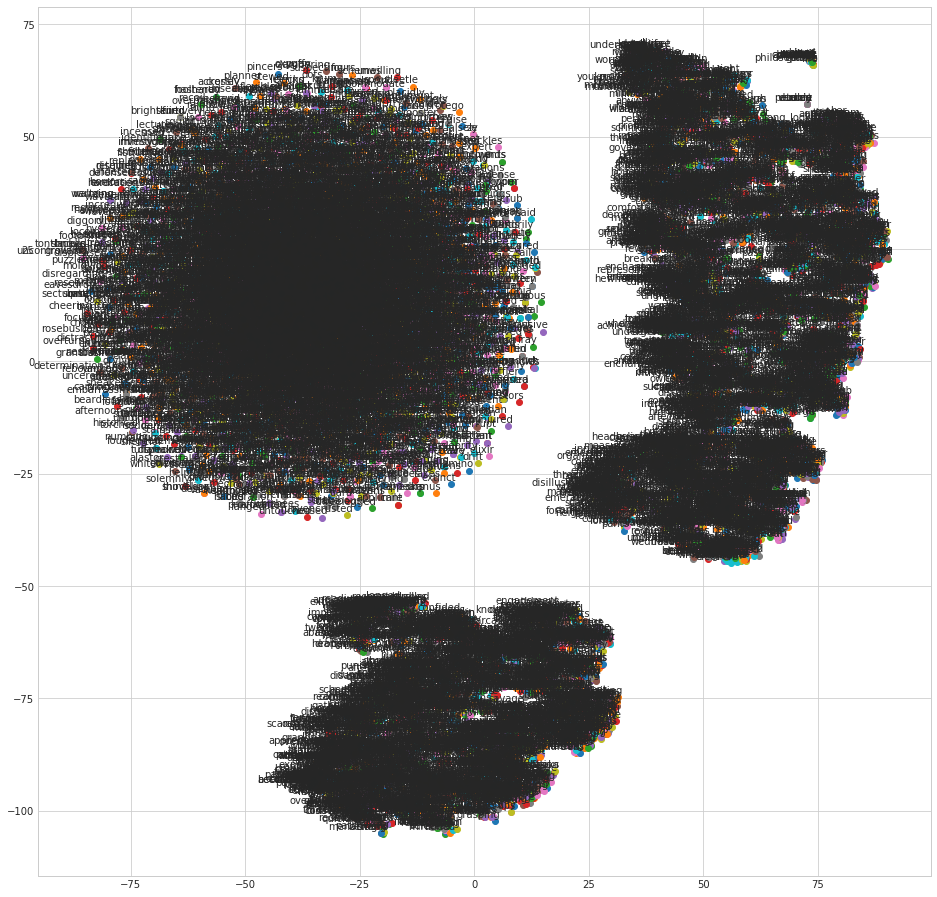

In [89]:
%time
tsne_plot(model)